# Experiment 1.1.Baseline
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Calculating distance in feature space experiments- 1.1.baseline <br>
Experiment detail : In this experiment we study different method's (baseline,activity_recog_method and activity recognition with variance loss method) for generating good reward fucntions required for observation learning . <br>


In [14]:
## Imports
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.models import Sequential
import random
import numpy as np
from PIL import Image
from os import listdir
from scipy.ndimage import imread
import os

# Custom scripts
import lscript as lsp
import modelling as md
import dataset as dset
from read_activations import *

In [10]:
height=112 
width=112 
channel=3
nb_class=3
cluster_length=8
strides=9
total_frames_in_seq=18
time_step=18
num_clusters= int( (total_frames_in_seq-cluster_length) / strides) + 1
feature_size=4608
#8192   #16384  #487


#### Loading Leeds Dataset

In [3]:
imagefolderpath= ('/nobackup/leopauly/View_invariance_Dataset/cupmove1compresscut_view0/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath))
vids=dset.viewpoint_data(time_step,height,width,channel,imagefolderpath,gray=False,normalisation=True)

True


(18, 112, 112, 3)


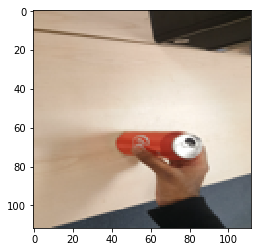

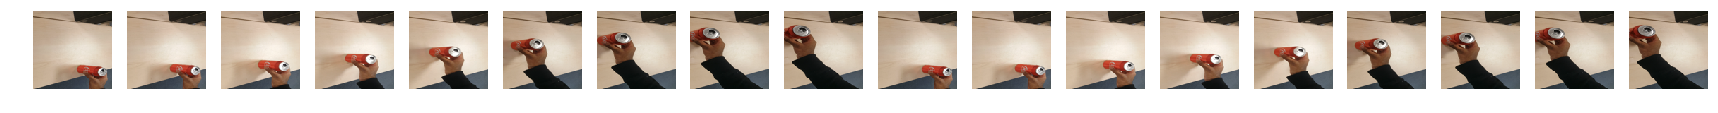

In [4]:
print (vids.shape)
y_=np.empty([1])
lsp.view_image(vids[3],image_details=False)
lsp.single_video_inline(vids,y_,time_step)

label:[  1.25986740e-321]
Video_seq shape: (18, 112, 112, 3) Label shape (1,)


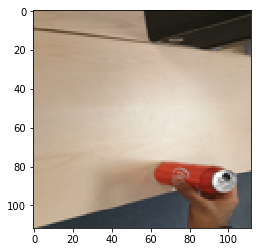

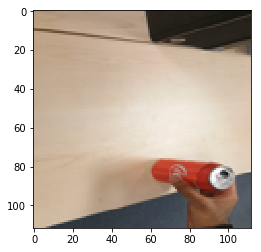

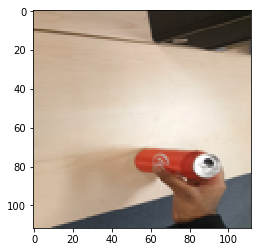

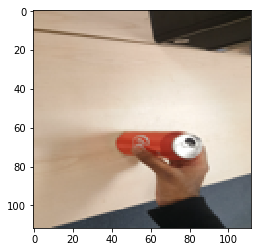

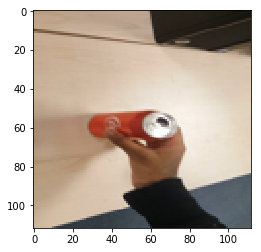

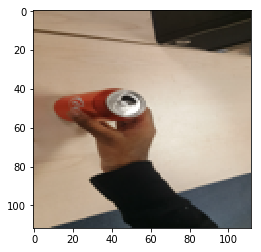

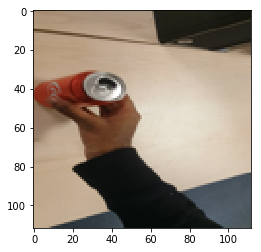

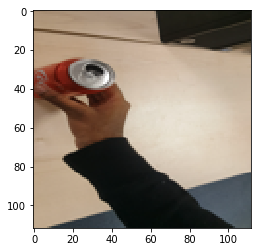

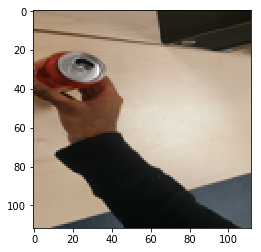

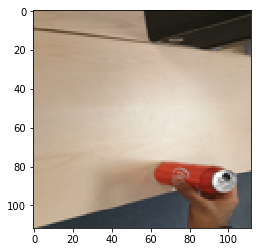

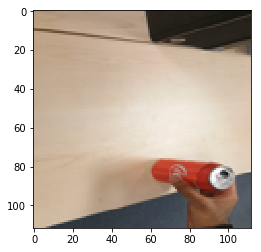

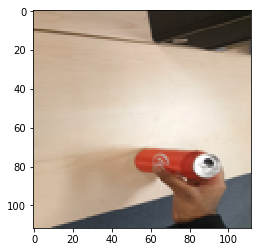

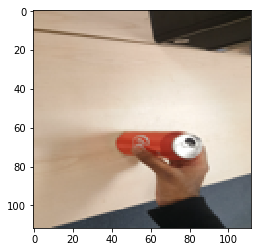

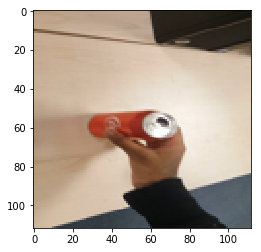

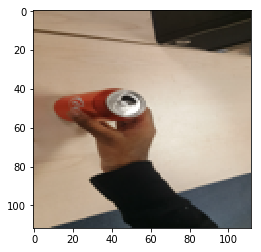

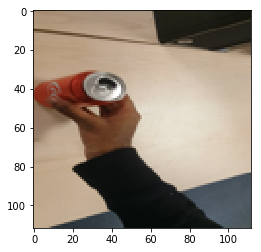

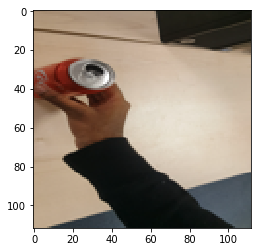

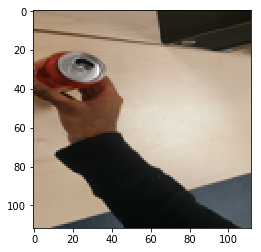

In [5]:
lsp.single_video_seq(vids,y_,time_step)

#### Loading model

In [23]:
base_model=md.get_vgg16_imagenet(summary=True,include_fc=False)
#last_layer = base_model.output
#x =Reshape((4098,-1))(last_layer)
#model = Model(input=base_model.input, output=x)
model=base_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

#### Extracting features

In [24]:
imagefolderpath= ('/nobackup/leopauly/View_invariance_Dataset/cupmove1compresscut_view0/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath))
vids=dset.viewpoint_data(time_step,height,width,channel,imagefolderpath,gray=False,normalisation=True)

True


In [27]:
## Splitting into clusters the video of source demonstration
x_demo = vids
x_demo_original=x_demo
x_demo =x_demo.reshape(1,x_demo.shape[0],height,width,channel)
clusters_demo=dset.clusters_with_strides(x_demo,num_clusters,cluster_length,height,width,channel,strides)
print('shape of clustered demo data:',clusters_demo.shape)

## Extraction of features
features_demo=np.zeros([num_clusters,feature_size])

sum_val=0
for i in range(cluster_length):
    frame=clusters_demo[0][i]
    #print('frame size',frame.shape)
    frame=frame.reshape(-1,height,width,channel)
    #print('frame size after reshape',frame.shape)
    temp_val=model.predict(frame)
    temp_val=temp_val.reshape(feature_size)
    sum_val=sum_val+temp_val
features_demo[0]=sum_val/cluster_length

sum_val=0
for i in range(cluster_length):
    frame=clusters_demo[1][i]
    #print('frame size',frame.shape)
    frame=frame.reshape(-1,height,width,channel)
    #print('frame size after reshape',frame.shape)
    temp_val=model.predict(frame)
    temp_val=temp_val.reshape(feature_size)
    sum_val=sum_val+temp_val
features_demo[1]=sum_val/cluster_length

(2, 8, 112, 112, 3)
shape of clustered demo data: (2, 8, 112, 112, 3)


In [31]:
imagefolderpath= ('/nobackup/leopauly/View_invariance_Dataset/cupmove1compresscut_view1/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath))
vids=dset.viewpoint_data(time_step,height,width,channel,imagefolderpath,gray=False,normalisation=True)

True


In [32]:
## Splitting into & displaying clusters of target actions
x_robo=vids
x_robo_original=x_robo
x_robo =x_robo.reshape(1,x_robo.shape[0],height,width,channel)
clusters_robo=dset.clusters_with_strides(x_robo,num_clusters,cluster_length,height,width,channel,strides)
print('shape of clustered robot data:',clusters_robo.shape)

(2, 8, 112, 112, 3)
shape of clustered robot data: (2, 8, 112, 112, 3)


In [33]:
## Extraction of features
features_robo=np.zeros([num_clusters,feature_size])

sum_val=0
for i in range(cluster_length):
    frame=clusters_robo[0][i]
    #print('frame size',frame.shape)
    frame=frame.reshape(-1,height,width,channel)
    #print('frame size after reshape',frame.shape)
    temp_val=model.predict(frame)
    temp_val=temp_val.reshape(feature_size)
    sum_val=sum_val+temp_val
features_robo[0]=sum_val/cluster_length

sum_val=0
for i in range(cluster_length):
    frame=clusters_robo[1][i]
    #print('frame size',frame.shape)
    frame=frame.reshape(-1,height,width,channel)
    #print('frame size after reshape',frame.shape)
    temp_val=model.predict(frame)
    temp_val=temp_val.reshape(feature_size)
    sum_val=sum_val+temp_val
features_robo[1]=sum_val/cluster_length

#### Extracting reward function

In [34]:
distance=np.ones([num_clusters,feature_size])
reward=np.ones([num_clusters,1])
for i in range(num_clusters):
    distance[i] = features_demo[i]-features_robo[i]
    reward[i]=-(np.linalg.norm(distance[i]))
print(reward)
print(distance)

[[-19.60053819]
 [-19.29296617]]
[[-0.42314002  0.         -0.01487407 ...,  0.         -0.53229702  0.        ]
 [ 0.41188005  0.         -0.11659819 ...,  0.         -0.04953283  0.        ]]


In [ ]:
y_vlaues=list((range(num_clusters)))
lsp.plot_values_with_legends(y_vlaues,reward,'reward','clusters','value','reward function',color='red',ylim=True)

#### Displaying cluster

In [ ]:
## Clusters from demos
for i in range(num_clusters):
    cluster_id=i
    y_d=np.repeat(y_,num_clusters)
    print('cluster no: ',i)
    display=clusters_demo.reshape(clusters_demo.shape[0],clusters_demo.shape[1],clusters_demo.shape[2],clusters_demo.shape[3],clusters_demo.shape[4])
    lsp.view_video_inline(display,y_d,cluster_length,cluster_id)

In [ ]:
## Clusters from robot action
y_r=np.repeat(y_,num_clusters)
for i in range(num_clusters):
    cluster_id=i 
    print('cluster no: ',i)
    display=clusters_robo.reshape(clusters_robo.shape[0],clusters_robo.shape[1],clusters_robo.shape[2],clusters_robo.shape[3],clusters_robo.shape[4])
    lsp.view_video_inline(display,y_r,cluster_length,cluster_id)

#### Displaying full video sequences

In [ ]:
## Demo / Source video
y_=np.zeros([1])
lsp.view_video_inline(x_demo_original,y_,time_step,0)
lsp.view_video_seq(x_demo_original,y_,time_step,0)

In [ ]:
### Target / robot video
y_=np.zeros([1])
lsp.view_video_inline(x_robo_original,y_,time_step,0)
lsp.view_video_seq(x_robo_original,y_,time_step,0)